# __ Import modules

In [1]:
import os
import pickle
from configparser import ConfigParser
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# __ Init variables and objects

In [2]:
config = ConfigParser(interpolation=None)
config.read('config.ini')


['config.ini']

In [3]:
DATE = datetime.datetime.now().strftime("%d%m%y-%S%f")[:-4]
DATE

'171023-3917'

In [4]:
DATASET_FULL_PATH = config['PATH']['dataset_full_path']
DATASET_FULL_PATH

'data/231017_kaggle/data-raw/train.csv'

In [5]:
DATASET_DIR = config['PATH']['dataset_dir']
DATASET_DIR

### Create dirs for output and data proc
for i in ['data-proc', 'models']:
    path_to_create = os.path.join(DATASET_DIR, i)
    if i not in os.listdir(DATASET_DIR):
        os.makedirs(path_to_create)
        print(f"[INFO] Created path: {path_to_create}")
    else:
        print(f"[INFO] Path already exists: {path_to_create}")

# path to save proc data
DATA_PROC_DIRS = os.path.join(DATASET_DIR, 'data-proc')
# path to save ML models
ML_DIRS = os.path.join(DATASET_DIR, 'models')


[INFO] Path already exists: data/231017_kaggle\data-proc
[INFO] Path already exists: data/231017_kaggle\models


# Exploratory Data Analysis

In [6]:
"""
Loading the dataset:

Variables:
- PassengerId: a number that identifies each passenger
- Name: the full name of a passenger
- Sex
- Age
- Pclass: the class in which the passenger was traveling: first, second, or third
- SibSp: the number of siblings and spouse of the passenger (0 if the passenger is traveling alone)
- Parch: the number of parents and children of the passenger (0 if the passenger is traveling alone)
- Ticket: ticket number
- Fare: the fare the passenger paid in British pounds
- Cabin: the cabin in which the passenger was traveling
- Embarked: the port in which the passenger embarked: "C" for Cherbourg, "Q" for Queenstown, "S" for Southampton
- Survived
"""

# Loading the dataset
df_raw = pd.read_csv(DATASET_FULL_PATH)
df_raw.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# All variables

print(f"The dataset has {len(df_raw)} rows and {len(df_raw.columns)} variables")

The dataset has 891 rows and 12 variables


(891, 12)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


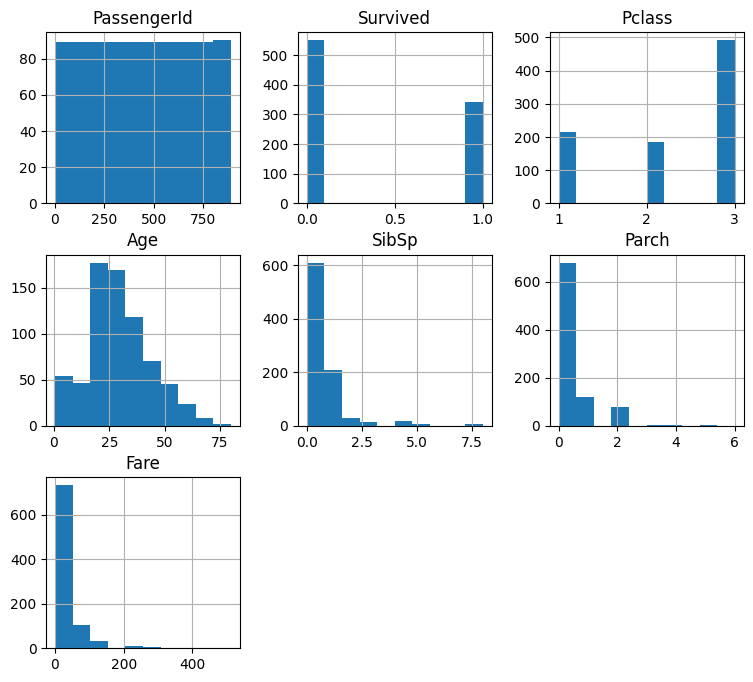

In [8]:
# Numerical continuous variables
print(df_raw.shape)

df_raw.hist(figsize=(9,8));
df_raw.describe()


In [9]:
# Categorical variables
print('Sex counts:')
print( df_raw['Sex'].value_counts() )

print('Embarked counts:')
print( df_raw['Embarked'].value_counts() )

Sex counts:
male      577
female    314
Name: Sex, dtype: int64
Embarked counts:
S    644
C    168
Q     77
Name: Embarked, dtype: int64


The dataset has 891 rows
Columns (features of the dataset):
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
342 passengers survived out of 891


Text(0.5, 1.0, 'Survived (1) vs deceased (0)')

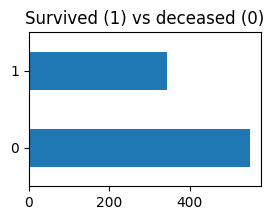

In [10]:
# exploring the dataset
print("The dataset has", len(df_raw), "rows")
print("Columns (features of the dataset):")
print(list(df_raw.columns))
print(sum(df_raw['Survived']),'passengers survived out of',len(df_raw))


df_raw['Survived'].value_counts().plot(kind='barh', figsize=(3,2))
plt.title('Survived (1) vs deceased (0)')

# Data Cleaning

In [56]:
def pipeline_1(df_raw):
    """Cleaning stage"""
    ### Clean the data up
    df_clean_0 = df_raw.copy(deep=True)
    ### Check how many columns have missing values
    print(f"[INFO] Missing values per feature BEFORE cleaning: \n{df_clean_0.isna().sum()}")
    print('-'*50)
    ### It seems that the 'cabin' feature has too many missing values, so we shall drop it
    df_clean_1 = df_clean_0.drop('Cabin', axis=1)
    df_clean_1.head()
    ### For the `Age` column, let's fill in the missing values with the median of all ages
    ### Also do the same for the other numeric columns
    for i in 'Age', 'Fare':
        median_value = df_clean_1[i].median()
        df_clean_1[i] = df_clean_1[i].fillna(median_value)
        df_clean_1.head()
    ### For `Embarked` column, let's make a new category for unknown ports of embarkment - `U`
    df_clean_1['Embarked'] = df_clean_1['Embarked'].fillna('U')
    df_clean_1 = df_clean_1[df_clean_1['Embarked'] != 'U']
    ### Check missing values post-processing
    print(f"[INFO] Missing values per feature AFTER cleaning: \n{df_clean_1.isna().sum()}")
    print('-'*50)
    ### Save data if needed
    if config['SAVE']['save-file'] == 'yes':
        print('[INFO] Your file will be saved.')
        df_clean_1.to_csv(f'{DATA_PROC_DIRS}/{DATE}_data-clean.csv', index=False)
    else:
        print('[INFO] Your file will NOT be saved.')
    return df_clean_1

clean_data = pipeline_1(df_raw)


[INFO] Missing values per feature BEFORE cleaning: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------------------------------------
[INFO] Missing values per feature AFTER cleaning: 
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
--------------------------------------------------
[INFO] Your file will NOT be saved.


# Data preprocessing

For preprocessing, we can manipulate the features in the following ways:
- One-hot encoding;
- Binning;
- Feature selection;

In [62]:
clean_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [66]:
def pipeline_2(df):
    """preprocessing data for ML training"""
    ### Feature selection
    #     Some features are unique for each passenger, 
    # such as passengerId, Name, and Ticket; therefore, let's delete them:
    df1 = df.drop(columns=['Name', 'Ticket', 'PassengerId'], axis=1)
    ### One-hot encoding
    ### The best strategy to deal with categorical data is to hot-encode it.
    ### in our case, these are features `Sex` and `Embarked`
    for i in ['Sex', 'Embarked', 'Pclass']:
        columns = pd.get_dummies(df1[i], prefix=i)
        # concatenate the hot-encoded columns with the original dataframe
        df1 = pd.concat([df1, columns], axis=1)
        df1 = df1.drop([i], axis=1)
    ### Binning
    """
    Now let's do some binning - turning numerical data into categorical data. 
    We usually do this in features with lots of unknown values; 
    in our cases, in the feature "Age" we handled a lot of missing values, 
    therefore, let's bin the age into categories:
    """
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
    categorized_age = pd.cut(df1['Age'], bins)
    df1['Categorized_age'] = categorized_age
    df1 = df1.drop(['Age'], axis=1)
    categorized_age_columns = pd.get_dummies(df1['Categorized_age'], prefix='Categorized_age')
    df1 = pd.concat([df1, categorized_age_columns], axis=1)
    df1 = df1.drop(['Categorized_age'], axis=1)
    ### Normalize `Fare` by log
    df1['Fare'] = df1['Fare'].replace(0, 0.1)
    df1['Fare'] = np.log10(df1['Fare'])
    ### Save preproc file
    if config['SAVE']['save-file'] == 'yes':
        print('[INFO] Your file will be saved.')
        df1.to_csv(f"{DATA_PROC_DIRS}/{DATE}_data-preproc.csv", index=None)
    else:
        print('[INFO] Your file will NOT be saved.')
    return df1

df_preproc = pipeline_2(clean_data)
df_preproc.head()

[INFO] Your file will NOT be saved.


,Survived,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,"Categorized_age_(0, 10]","Categorized_age_(10, 20]","Categorized_age_(20, 30]","Categorized_age_(30, 40]","Categorized_age_(40, 50]","Categorized_age_(50, 60]","Categorized_age_(60, 70]","Categorized_age_(70, 80]"
0,0,1,0,0.860338,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1,1,1,0,1.852988,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0.898999,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
3,1,1,0,1.725095,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0.905796,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0


# Training the model

We'll train the following models:
- Logistic regression (perceptron)
- Decision tree
- Naive Bayes
- SVM
- random forest
- gradient boosted tree
- AdaBoost model

In [74]:
def pipeline_3(df):
    """Split into features and labels"""
    data = df.copy(deep=True)
    # Features-labels split and train-validation split
    # Features - all the columns except "Survived"
    features = data.drop(['Survived'], axis=1)
    labels = data['Survived']
    print(features.columns)
    print(labels.shape)
    return features, labels

features_train_validation, labels_train_validation = pipeline_3(df_preproc)


Index(['SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Categorized_age_(0, 10]', 'Categorized_age_(10, 20]',
       'Categorized_age_(20, 30]', 'Categorized_age_(30, 40]',
       'Categorized_age_(40, 50]', 'Categorized_age_(50, 60]',
       'Categorized_age_(60, 70]', 'Categorized_age_(70, 80]'],
      dtype='object')
(889,)


In [76]:
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train_validation, labels_train_validation,
    test_size=0.2,
    random_state=42
)

print(f"For training, we will use {len(features_train)} features and {len(labels_train)} labels.")
print(f"For validation, we will use {len(features_validation)} features and {len(labels_validation)} labels.")


For training, we will use 711 features and 711 labels.
For validation, we will use 178 features and 178 labels.


In [77]:
lr_model = LogisticRegression()
lr_model.fit(features_train, labels_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(features_train, labels_train)

nb_model = GaussianNB()
nb_model.fit(features_train, labels_train)

svm_model = SVC()
svm_model.fit(features_train, labels_train)

rf_model = RandomForestClassifier()
rf_model.fit(features_train, labels_train)

gb_model = GradientBoostingClassifier()
gb_model.fit(features_train, labels_train)

ab_model = AdaBoostClassifier()
ab_model.fit(features_train, labels_train)


AdaBoostClassifier()

In [78]:
"""
Evaluating the models,
metric - accuracy

The model with the highest accuracy (81%) seems to be gradient boosting
"""
accuracy_scores = {}
models = [lr_model, dt_model, nb_model, svm_model, rf_model, gb_model, ab_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM', 'Random forest', 'Gradient Boosting', 'AdaBoost']

for i,j in zip( models, model_names ):
	### Method 1
	# accuracy_scores[j] = i.score(features_validation, labels_validation)
	### Method 2
	predicted_labels = i.predict(features_validation)
	accuracy_scores[j] = accuracy_score(labels_validation, predicted_labels)

# Sort the dictionary based on value
accuracy_scores2 = dict(sorted(accuracy_scores.items(), key=lambda item: item[1], reverse=True))

print('Accuracies (high -> low): ')
for i in accuracy_scores2:
	print(f" - {i}: {accuracy_scores2[i]:.2f}")


Accuracies (high -> low): 
 - AdaBoost: 0.83
 - Decision Tree: 0.82
 - Gradient Boosting: 0.82
 - Logistic Regression: 0.81
 - SVM: 0.81
 - Random forest: 0.80
 - Naive Bayes: 0.76


In [79]:
"""
Evaluating the models,
metric - F1 score

The highest score here is, once again, that of gradient boosting
(F1 score = 0.74)
"""
# metric = F1 score

f1_scores = {}
models = [lr_model, dt_model, nb_model, svm_model, rf_model, gb_model, ab_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM', 'Random forest', 'Gradient Boosting', 'AdaBoost']

for i,j in zip( models, model_names ):
	predicted_labels = i.predict(features_validation)
	f1_scores[j] = f1_score(labels_validation, predicted_labels)

# Sort the dictionary based on value
f1_scores2 = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

print('F1 score values (high -> low): ')
for i in f1_scores2:
	print(f" - {i}: {f1_scores2[i]:.2f}")



F1 score values (high -> low): 
 - AdaBoost: 0.79
 - Decision Tree: 0.77
 - Logistic Regression: 0.76
 - Gradient Boosting: 0.76
 - SVM: 0.75
 - Random forest: 0.75
 - Naive Bayes: 0.73


# Finetuning

Above we did the training with the default hyperparameters.

Now let's finetune them by a Grid search. Let's choose Gradient Boosting for the grid search

In [80]:
features_trainValidation = pd.concat([features_train, features_validation], ignore_index=True)
print(features_trainValidation.shape)

labels_trainValidation = pd.concat([labels_train, labels_validation], axis='rows')
print(labels_trainValidation.shape)

(889, 19)
(889,)


In [81]:
grid_search_parameters = {
# 	'loss': ['log_loss'],
	'min_samples_split': [2,5,8,11],
	# 'min_samples_leaf': [1,4,7,9],
	# 'max_depth': [1,2,3,4], 
	# 'learning_rate': [0.1, 0.5, 1],
	# 'n_estimators': [1, 40, 80, 120]
}

gb_grid = GradientBoostingClassifier()
gb_grid2 = GridSearchCV(estimator = gb_grid, param_grid = grid_search_parameters)
gb_grid2.fit(features_trainValidation, labels_trainValidation)
print(gb_grid2.cv_results_)
# gb_grid2.fit(features_train, labels_train)

gb_winner = gb_grid2.best_estimator_
print(gb_winner)
# accuracy on basically train+validation set
print(gb_winner.score(features_trainValidation, labels_trainValidation))


{'mean_fit_time': array([0.08106093, 0.08054056, 0.0927103 , 0.08336878]), 'std_fit_time': array([0.00531014, 0.00547841, 0.010582  , 0.00766784]), 'mean_score_time': array([0.00220084, 0.00201964, 0.00219278, 0.00200229]), 'std_score_time': array([4.00189459e-04, 2.08340190e-05, 4.15031634e-04, 1.95581142e-05]), 'param_min_samples_split': masked_array(data=[2, 5, 8, 11],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_samples_split': 2}, {'min_samples_split': 5}, {'min_samples_split': 8}, {'min_samples_split': 11}], 'split0_test_score': array([0.83146067, 0.82022472, 0.83146067, 0.82022472]), 'split1_test_score': array([0.8258427 , 0.82022472, 0.83707865, 0.8258427 ]), 'split2_test_score': array([0.85393258, 0.85393258, 0.85393258, 0.84831461]), 'split3_test_score': array([0.8258427 , 0.81460674, 0.81460674, 0.79775281]), 'split4_test_score': array([0.81355932, 0.81355932, 0.81920904, 0.81920904]), 'mean_test_score': a

# Test

Now let's test our chosen model on the test dataset:

## Test data preproc

In [83]:
features_test = pd.read_csv('data/kaggle/data-raw/test.csv')
features_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [86]:
labels_test = pd.read_csv('data/kaggle/data-raw/gender_submission.csv')
labels_test = labels_test['Survived']
labels_test


0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

In [121]:
### Data Cleaning
# cleaning up the data
df_clean_0 = features_test.copy(deep=True)

# Check out how many columns have missing values
print(f"Missing values per feature: \n{df_clean_0.isna().sum()}")
# It seems that the "cabin" feature has too many missing values
# so let's drop "cabin"
clean_data = df_clean_0.drop('Cabin', axis=1)
print('-'*50)

# For the "Age" column, let's fill in the missing values with the median of all ages
median_age = df_clean_0['Age'].median()
clean_data['Age'] = clean_data['Age'].fillna(median_age)
# for Embarked column, let's make a new category "U" - for unknown port of embarkment
clean_data['Embarked'] = clean_data['Embarked'].fillna('U')
# For Fare column, median
median_fare = df_clean_0['Fare'].median()
clean_data['Fare'] = clean_data['Fare'].fillna(median_fare)
print('Missing values post-processing:')
print(clean_data.isna().sum())
clean_data.head()

### Feature selection
df_preproc_0 = clean_data.copy(deep=True)
df_preproc_0.drop(columns=['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
df_preproc_0.head()

### One-hot encoding
gender_columns = pd.get_dummies(df_preproc_0['Sex'], prefix='Sex')
embarked_columns = pd.get_dummies(df_preproc_0["Embarked"], prefix="Embarked")
# Concatenate the hot-encoded columns with the original dataframe
df_preproc_0 = pd.concat([df_preproc_0, gender_columns], axis=1)
df_preproc_0 = pd.concat([df_preproc_0, embarked_columns], axis=1)
df_preproc_0 = df_preproc_0.drop(['Sex', 'Embarked'], axis=1)
df_preproc_0.head()

### Binning
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
categorized_age = pd.cut(df_preproc_0['Age'], bins)
df_preproc_0['Categorized_age'] = categorized_age
df_preproc_0.drop(["Age"], axis=1, inplace=True)
cagegorized_age_columns = pd.get_dummies(df_preproc_0['Categorized_age'], prefix='Categorized_age')
df_preproc_0 = pd.concat([df_preproc_0, cagegorized_age_columns], axis=1)
df_preproc_0 = df_preproc_0.drop(['Categorized_age'], axis=1)
df_preproc_0.head()

"""
Let's normalize "Fare" by log
"""
print(df_preproc_0['Fare'].min())
df_preproc_0['Fare'].replace(0, 0.1, inplace=True)
print(df_preproc_0['Fare'].min())
df_preproc_0['Fare'] = np.log10(df_preproc_0['Fare'])
df_preproc_0


Missing values per feature: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------------------------------------
Missing values post-processing:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
0.0
0.1


,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,"Categorized_age_(0, 10]","Categorized_age_(10, 20]","Categorized_age_(20, 30]","Categorized_age_(30, 40]","Categorized_age_(40, 50]","Categorized_age_(50, 60]","Categorized_age_(60, 70]","Categorized_age_(70, 80]"
0,3,0,0,0.893717,0,1,0,1,0,0,0,0,1,0,0,0,0
1,3,1,0,0.845098,1,0,0,0,1,0,0,0,0,1,0,0,0
2,2,0,0,0.986212,0,1,0,1,0,0,0,0,0,0,0,1,0
3,3,0,0,0.937643,0,1,0,0,1,0,0,1,0,0,0,0,0
4,3,1,1,1.089464,1,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0.905796,0,1,0,0,1,0,0,1,0,0,0,0,0
414,1,0,0,2.037028,1,0,1,0,0,0,0,0,1,0,0,0,0
415,3,0,0,0.860338,0,1,0,0,1,0,0,0,1,0,0,0,0
416,3,0,0,0.905796,0,1,0,0,1,0,0,1,0,0,0,0,0


## Test data preproc 2 (231017)

In [87]:
features_test = pd.read_csv('data/231017_kaggle/data-raw/test.csv')
labels_test = pd.read_csv('data/231017_kaggle/data-raw/gender_submission.csv')
labels_test = labels_test['Survived']

df_test = pd.concat(
    [features_test, labels_test],
    axis='columns',
    sort=False
)
df_test


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [90]:
clean_test_data = pipeline_1(df_test)


[INFO] Missing values per feature BEFORE cleaning: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64
--------------------------------------------------
[INFO] Missing values per feature AFTER cleaning: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Survived       0
dtype: int64
--------------------------------------------------
[INFO] Your file will NOT be saved.


In [91]:
preproc_test_data = pipeline_2(clean_test_data)


[INFO] Your file will NOT be saved.


In [92]:
features_test, labels_test = pipeline_3(preproc_test_data)

Index(['SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Categorized_age_(0, 10]', 'Categorized_age_(10, 20]',
       'Categorized_age_(20, 30]', 'Categorized_age_(30, 40]',
       'Categorized_age_(40, 50]', 'Categorized_age_(50, 60]',
       'Categorized_age_(60, 70]', 'Categorized_age_(70, 80]'],
      dtype='object')
(418,)


## Test

In [94]:
predictions = gb_winner.predict( features_test )
print("Performance metrics of the final model:")
print(f" - Accuracy = {accuracy_score( labels_test, predictions ):.3f}")
print(f" - Precision = {precision_score( labels_test, predictions ):.3f}")
print(f" - Recall = {recall_score( labels_test, predictions ):.3f}")
print(f" - F1 = {f1_score( labels_test, predictions ):.3f}")

Performance metrics of the final model:
 - Accuracy = 0.904
 - Precision = 0.894
 - Recall = 0.836
 - F1 = 0.864


# Save model

In [95]:
if config['SAVE']['save-file'] == 'yes':
    print('[INFO] Your model will be saved.')
    pickle.dump(gb_winner, open(f'{ML_DIRS}/{DATE}_ML_model_Titanic.sav', 'wb'))
else:
    print('[INFO] Your file will NOT be saved.')


[INFO] Your file will NOT be saved.
